In [1]:
import math
from scipy import interpolate
import gsw
from xmitgcm import open_mdsdataset
import numpy as np
import xarray as xr
import copy
from matplotlib import pyplot as plt
import matplotlib.colors
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 16, 'axes.labelsize' : 16,
      'legend.fontsize' : 16,'legend.handlelength': 2})

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

In [3]:
rhonil = 999.8
rhoconst = 999.8
tref = 20
sref = 35
sbeta = 7.4e-4
talpha = 2e-4


def get_sigma(temp, lon, lat, lev):
    m = lon.shape[0]
    n = lat.shape[0]
    l = lev.shape[0]

    sigma = linear_rho(35, temp, sref, tref) - 1000

    ds_sigma = xr.DataArray(sigma[:, :, :], coords={'Z': lev, 'YC': lat, 'XC': lon},
                            dims=['Z', 'YC', 'XC'])

    return ds_sigma


def compute_pv(temp, vorticity, lon, lat, lev):

    m = lon.shape[0]
    n = lat.shape[0]
    l = lev.shape[0]

    sigma = linear_rho(35, temp, sref, tref) - 1000

    dz = np.zeros((l-1, n, m))
    f = np.zeros((l-1, n, m))
    ln, lt = np.meshgrid(lon, lat)

    for k in np.arange(0, l-1, 1):
        f[k, :, :] = gsw.f(lt)
        dz[k, :, :] = np.diff(np.abs(lev))[k]

    dz_r = 1 / dz
    d0_r = 1 / 1025

    dden = np.diff(sigma, n=1, axis=0)

    pv = f * dden * dz_r * d0_r * 1e10

    ds_pv = xr.DataArray(
        pv, coords={'Z': lev[:-1], 'YC': lat, 'XC': lon}, dims=['Z', 'YC', 'XC'])

    return ds_pv


def compute_ipv(pv, sigma, iso):

    z = np.arange(10, 1200, 10)

    pv_z = np.zeros((z.shape[0], pv.shape[1], pv.shape[2]))
    sigma_z = np.zeros((z.shape[0], sigma.shape[1], sigma.shape[2]))

    for n in np.arange(0, z.shape[0], 1):
        pv_z[n, :, :] = pv.interp(Z=-z[n])
        sigma_z[n, :, :] = sigma.interp(Z=-z[n])

    pv_iso = np.zeros((len(iso), pv.shape[1], pv.shape[2]))
    pv_iso[:, :, :] = np.nan

    dep_iso = np.zeros((len(iso), pv.shape[1], pv.shape[2]))
    dep_iso[:, :, :] = np.nan
    for k in np.arange(0, len(iso), 1):
        for i in np.arange(0, pv.shape[2], 1):
            for j in np.arange(0, pv.shape[1], 1):

                den_tmp = sigma_z[:, j, i]
                pv_tmp = pv_z[:, j, i]

                id1 = np.where(den_tmp < iso[k])

                if np.size(id1) > 0 and np.size(id1) < len(z):

                    den1 = den_tmp[id1[0][-1]]
                    den2 = den_tmp[id1[0][-1] + 1]

                    if den1 < den2:
                        fun1 = interpolate.interp1d(
                            [den1, den2], [pv_tmp[id1[0][-1]], pv_tmp[id1[0][-1] + 1]])
                        pv_iso[k, j, i] = fun1(iso[k])

                        fun2 = interpolate.interp1d(
                            [den1, den2], [z[id1[0][-1]], z[id1[0][-1] + 1]])
                        dep_iso[k, j, i] = fun2(iso[k])

    return pv_iso, dep_iso


def linear_rho(s, t, sref, tref):
    rho = 1000 * (sbeta * (s - sref) - talpha * (t - tref)) + 1025
    return rho


def clim_thermo(sigma, temp, u, v, lon, lat, lev, iso):

    m = lon.shape[0]
    n = lat.shape[0]
    l = lev.shape[0]

    z = np.arange(10, 800, 10)

    sigma_z = np.zeros((z.shape[0], sigma.shape[1], sigma.shape[2]))
    temp_z = np.zeros((z.shape[0], temp.shape[1], temp.shape[2]))
    u_z = np.zeros((z.shape[0], u.shape[1], u.shape[2]))
    v_z = np.zeros((z.shape[0], v.shape[1], v.shape[2]))

    for k in np.arange(z.shape[0]):
        sigma_z[k, :, :] = sigma.interp(Z=-z[k])
        temp_z[k, :, :] = temp.interp(Z=-z[k])
        u_z[k, :, :] = u.interp(Z=-z[k])
        v_z[k, :, :] = v.interp(Z=-z[k])


    dep_iso = np.zeros((n, m))
    dep_iso[:, :] = np.nan

    temp_tc = np.zeros((n, m))
    temp_tc[:, :] = np.nan
    u_tc = np.zeros((n, m))
    u_tc[:, :] = np.nan
    v_tc = np.zeros((n, m))
    v_tc[:, :] = np.nan

    for i in np.arange(0, m, 1):
        for j in np.arange(0, n, 1):

            den_tmp = sigma_z[:, j, i]
            temp_tmp = temp_z[:, j, i]
            u_tmp = u_z[:, j, i]
            v_tmp = v_z[:, j, i]

            id1 = np.where(den_tmp < iso)

            if np.size(id1) > 0 and np.size(id1) < len(z):

                den1 = den_tmp[id1[0][-1]]
                den2 = den_tmp[id1[0][-1] + 1]

                if den1 < den2:

                    fun = interpolate.interp1d(
                        [den1, den2], [z[id1[0][-1]], z[id1[0][-1] + 1]])
                    dep_iso[j, i] = fun(iso)

                    temp_tc[j, i] = np.nanmean(temp_tmp)
                    u_tc[j, i] = np.nanmean(u_tmp)
                    v_tc[j, i] = np.nanmean(v_tmp)

    return dep_iso, temp_tc, u_tc, v_tc


def smooth_2d(data):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    data_new[:, :] = np.nan
    for i in np.arange(1, m, 1):
        for j in np.arange(1, n, 1):
            tmp = data[i-1:i+2, j-1:j+2]
            if math.isnan(data[i, j]) == False:
                data_new[i, j] = np.nanmean(tmp)
    return data_new

In [4]:
t0 = 280
t1 = 300

data_dir = '/WORK/sio_goc03/pv_flux/coarse_0918/no_diff/'
ds = open_mdsdataset(data_dir, prefix={'etan_ave', 'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds.XC
lat1 = ds.YC
lev1 = ds.Z

ssh1 = ds['ETAN'][t0:t1, :, :]
ssh1 = ssh1.mean('time')

t0 = 30
t1 = 50
    
data_dir = '/WORK/sio_goc03/pv_flux/fine_0918/den_jump2/'
ds = open_mdsdataset(data_dir, prefix={'etan_ave', 'xyMom_ave', 'theta_ave'}).chunk()

lon2 = ds.XC
lat2 = ds.YC
lev2 = ds.Z

ssh2 = ds['ETAN'][t0:t1, :, :]
ssh2 = ssh2.mean('time')

temp2 = ds['THETA'][t0:t1, :, :, :]
temp2 = temp2.mean(dim='time')
temp2 = temp2.where(temp2 > 0)

den2 = linear_rho(35, temp2, sref, tref) - 1000


data_dir = '/WORK/sio_goc03/pv_flux/fine_0918/crun_0.3/'
ds = open_mdsdataset(data_dir, prefix={'etan_ave', 'xyMom_ave', 'theta_ave'}).chunk()

lon3 = ds.XC
lat3 = ds.YC
lev3 = ds.Z

ssh3 = ds['ETAN'][t0:t1, :, :]
ssh3 = ssh3.mean('time')

temp3 = ds['THETA'][t0:t1, :, :, :]
temp3 = temp3.mean(dim='time')
temp3 = temp3.where(temp3 > 0)

den3 = linear_rho(35, temp3, sref, tref) - 1000

data_dir = '/WORK/sio_goc03/pv_flux/fine_32/crun/'
ds = open_mdsdataset(data_dir, prefix={'etan_ave', 'xyMom_ave', 'theta_ave'}).chunk()

lon4 = ds.XC
lat4 = ds.YC
lev4 = ds.Z

ssh4 = ds['ETAN'][t0:t1, :, :]
ssh4 = ssh4.mean('time')

temp4 = ds['THETA'][t0:t1, :, :, :]
temp4 = temp4.mean(dim='time')
temp4 = temp4.where(temp4 > 0)

den4 = linear_rho(35, temp4, sref, tref) - 1000

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

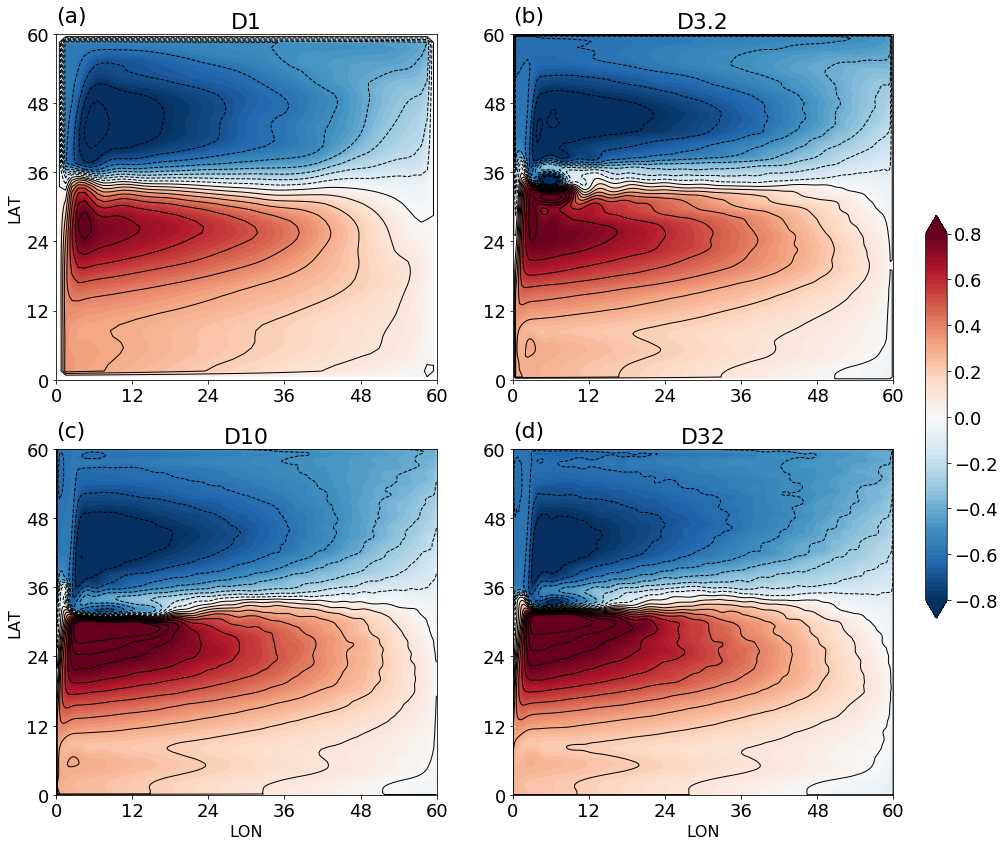

In [5]:
levs1 = np.arange(-0.8, 0.8+0.01, 0.02)
levs2 = np.arange(-1.0, 1.0+0.01, 0.1)

fig = plt.figure(figsize=(15, 14))

plt.subplot(221)
h1 = plt.contourf(lon1, lat1, ssh1, levs1, cmap='RdBu_r',
                  extend='both', vmin=-0.8, vmax=0.8)

h2 = plt.contour(lon1, lat1, ssh1, levs2, colors='k', linewidths=1)
#plt.clabel(h2, fmt='%2.1f', fontsize=12, colors='gold')

x_ticks = np.arange(0, 61, 12)
y_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlim(0, 60)
plt.ylim(0, 60)
#plt.xlabel('LON')
plt.ylabel('LAT')
plt.title('D1', size=22)
plt.text(0, 62, '(a)', size=22)

plt.subplot(222)

h1 = plt.contourf(lon3, lat3, ssh3, levs1, cmap='RdBu_r',
                  extend='both', vmin=-0.8, vmax=0.8)


h2 = plt.contour(lon3, lat3, ssh3, levs2, colors='k', linewidths=1)
#plt.clabel(h2, fmt='%2.1f', fontsize=12, colors='gold')

x_ticks = np.arange(0, 61, 12)
y_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlim(0, 60)
plt.ylim(0, 60)
#plt.xlabel('LON')
#plt.ylabel('LAT')
plt.title('D3.2', size=22)
plt.text(0, 62, '(b)', size=22)

plt.subplot(223)

h1 = plt.contourf(lon2, lat2, ssh2, levs1, cmap='RdBu_r',
                  extend='both', vmin=-0.8, vmax=0.8)


h2 = plt.contour(lon2, lat2, ssh2, levs2, colors='k', linewidths=1)
#plt.clabel(h2, fmt='%2.1f', fontsize=12, colors='gold')

x_ticks = np.arange(0, 61, 12)
y_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xlabel('LON')
plt.ylabel('LAT')
#plt.title(r'0.1$^{\circ}$', size=20)
plt.title('D10', size=22)
plt.text(0, 62, '(c)', size=22)

plt.subplot(224)

h1 = plt.contourf(lon4, lat4, ssh4, levs1, cmap='RdBu_r',
                  extend='both', vmin=-0.8, vmax=0.8)


h2 = plt.contour(lon4, lat4, ssh4, levs2, colors='k', linewidths=1)
#plt.clabel(h2, fmt='%2.1f', fontsize=12, colors='gold')

x_ticks = np.arange(0, 61, 12)
y_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xlabel('LON')
#plt.ylabel('LAT')
plt.title('D32', size=22)
plt.text(0, 62, '(d)', size=22)

c_ticks = np.arange(-0.8, 0.8+0.1, 0.2)
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.4])
hc = fig.colorbar(h1, cax=cbar_ax, ticks=c_ticks)
#hc.set_label('SSH (m)', size=12)